# Workspace setup

In [ ]:
# !pip install pyxdameraulevenshtein

     |████████████████████████████████| 61kB 3.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyxdameraulevenshtein: filename=pyxDamerauLevenshtein-1.6.1-cp36-cp36m-linux_x86_64.whl size=85767 sha256=f558c8d24b9dda4da70fdbf76368cd39586bf20f59d0c0a67f306844f65637bd
  Stored in directory: /root/.cache/pip/wheels/d2/05/c3/989929774aa6f86a368f18f132bcc79ed7cb1ea65763c1dc09
Successfully built pyxdameraulevenshtein


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from scipy.stats import percentileofscore
from scipy.stats import iqr
from scipy.stats import skew
from scipy.stats import entropy
from scipy.spatial import distance
from scipy.stats import kurtosis
from sklearn.model_selection import GridSearchCV

from ipywidgets import IntProgress
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)
WORK_DIR = '/home/muhammadinan/Documents/GitHub/IoT_Classification/'

In [12]:
import sys

sys.path.append(f'{WORK_DIR}')

from BOS_Wrapper import BOS_Classifier
# from NLP_Classifier import NLP_Classifier
from TSC_1NN import TSC_1NN, DTWDistance

In [13]:
from heapq import nlargest

# EnsembleFramework

In [15]:
class EnsembleFramework:
    
    def __init__(self, criterion = 'topk', tuning = False, 
                 layers = [{'type' : 'NLP'}, {'type' : 'BOS', 'name' : 'DecisionTreeClassifier()'}], 
                 params = {'k' : [4, 1]}):
        self.criterion = criterion
        self.layers = layers
        self.params = params
        self.tuning = tuning

    def get_params(self, deep=True):
        return {"criterion": self.criterion, 
                "layers": self.layers,
                "params": self.params,
                "tuning": self.tuning}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # SoF filtering - receives in input the list of the class probabilities and the list of the remaining classes
    def survival(self, probs, classes):
        survived = []
  
        # selecting the probabilities of the remaining classes
        survived_probs = [probs[c] for c in classes]

        # mean and std
        media = np.mean(survived_probs)
        std_dev = np.std(survived_probs)
        
        # filtering based on sigma value
        for c in classes:
            if (probs[c] >= (media + self.params['sigma']*std_dev)):
                survived.append(c)
        
        # if the final list is empty, we select the most probable class
        if (len(survived) == 0):
            survived = nlargest(1, classes, key = lambda x : probs[x])
            
        return survived
    


    def fit(self, X_train, y_train):
        # class list
        self.classes = set(y_train)
        
        # classifier pipeline
        self.classifiers = []
        input_clf = []
        #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)
        
        # let's populate our pipeline
        for classifier in self.layers:
            if (classifier['type'] == 'BOS'):
                clf = BOS_Classifier(eval(classifier['name']))
            elif (classifier['type'] == 'NLP'):
                clf = NLP_Classifier()
            elif (classifier['type'] == 'TSC'):
                clf = eval(classifier['name'])
            clf.fit(X_train, y_train)
            #input_clf.append(clf)
            self.classifiers.append(clf)
          
        #self.classifiers = self.construct(input_clf, X_val, y_val)
 
    # populating our pipeline according to the maximum mean variance method
    # NOT USED IN THE FINAL VERSION
    def construct(self, candidates, X_val, y_val, max_iterations = 5):

        val_classes = [list(set(y_val))] * len(X_val)
        n_iter = 0
        selected = []
        probs = []

        for clf in candidates:
            probs.append(clf.predict_proba(X_val)) 

        if (self.criterion == 'sof'):
            while(any(x > 1 for x in [len(x) for x in val_classes]) and n_iter < max_iterations):
                n_iter = n_iter + 1
                print("iteration ", n_iter)
                max_variance, index = 0, 0
                for j, _ in enumerate(candidates):
                    variances = []
                    for i, series_probs in enumerate(probs[j]):
                        variances.append(np.var([series_probs[m] for m in val_classes[i]])) 

                    print("classifier number ", j, " has variance ", iqr(variances))
                    if iqr(variances) > max_variance :
                        max_variance = iqr(variances)
                        index = j
                print("the best classifier is the ", index)
                selected.append(candidates[index])

                for i, series_probs in enumerate(probs[index]):
                    val_classes[i] = self.survival(series_probs, val_classes[i])

        return selected      

    # dynamic prediction based on classifier confidence
    # NOT USED IN THE FINAL VERSION
    def predict_dinamic(self, X_test, max_iterations = 5, debug = False, y_test = None):

        length = X_test.shape[0]
        self.classes = [list(self.classes)] * len(X_test)

        f = IntProgress(min=0, max=length) # instantiate the bar
        display(f) # display the bar

        probs_list = []

        for clf in self.classifiers:
            probs_list.append(clf.predict_proba(X_test)) 

        for i in range(length):
              n_iter = 0
              if debug: print(i, "th istance\n", test_instance['metadata'])
              while(len(self.classes[i]) > 1 and n_iter < max_iterations):
                  n_iter = n_iter + 1
                  if debug: print("iterazione: ", n_iter)
                  max_variance, index, prob_best = 0, 0, []
                  for j, _ in enumerate(self.classifiers):
                      probs = probs_list[j][i]
                      restricted_probs = [probs[m] for m in self.classes[i]]
                      variance = max(restricted_probs)-min(restricted_probs)
                      #variance = np.var(restricted_probs)
                      #variance = entropy(restricted_probs)
                      if debug: print("classifier ", clf.__class__.__name__, " has variance ", variance)
                      if variance >= max_variance:
                          max_variance = variance
                          index = j
                          prob_best = probs
                  self.classes[i] = self.survival(prob_best, self.classes[i])
                  if debug: print("selected classes: ", self.classes[i])
                  if debug and y_test: print("true class is ", y_test[i], "\n")
                  if (n_iter == max_iterations):
                      self.classes[i] = nlargest(1, self.classes[i], key = lambda x : prob_best[x])
              f.value += 1

              

        return self.classes



    def predict(self, X_test):
        
        self.classes = [list(self.classes)] * len(X_test)
        for j, clf in enumerate(self.classifiers):
            probs = clf.predict_proba(X_test)
            if (self.tuning):
                X_test = self.ftuning(X_test, probs)
            # for each instance of the test set, we filter the clases with SoF
            for i, series_probs in enumerate(probs):
                    
                # if the classifier is the last one in the pipeline, we automatically select the most probable class
                if (j == (len(self.classifiers)-1)):
                    self.classes[i] = nlargest(1, self.classes[i], key = lambda x : series_probs[x])
                    
                #sof filtering
                elif (self.criterion == 'sof'):
                    self.classes[i] = self.survival(series_probs, self.classes[i])
                #topk filtering
                elif (self.criterion == 'topk'):
                    k = self.params['k'][j]
                    self.classes[i] = nlargest(k, self.classes[i], key = lambda x : series_probs[x])
                #qf filtering
                elif (self.criterion == 'qf'):
                    k = int(len(self.classes[i])*self.params['q'])
                    if (k == 0): k = 1
                    self.classes[i] = nlargest(k, self.classes[i], key = lambda x : series_probs[x])
            
        return self.classes  
    


    def ftuning(self, X_test, probs):
        for prob_list, (_, row) in zip(probs, X_test.iterrows()):
            row['statistics'] = row['statistics'][:-len(prob_list)]
            row['statistics'] = np.append(row['statistics'], prob_list) 
            
        return X_test
    
    def accuracy(self, classes, y_test):
        y_pred = []
        for pred in classes:
            y_pred.append(*pred)
            
        return accuracy_score(y_pred, y_test)*100

# Data preprocessing

Let's prepare our data so that it is compatible with our EnsembleFramework class. We extract the input data in a dictionary with keys 'statistics', 'metadata', 'timeseries', one for each algorithm type (respectively, BOS, NLP and TSC).


In [30]:
def import_dataset(name):
    y = []
    X = {'metadata': [], 'statistics' : [], 'timeseries' : []}

    csv_file = f'{WORK_DIR}' + '/Datasets/' + name + '.meta.csv'
    scaler = StandardScaler()

    with open(csv_file, 'r', encoding='utf-8') as dati:
        for row in dati:
            riga = row.strip().split(',')
            
            classe = int(riga[8])
            y.append(classe)
            
            valori = np.array(riga[9:]).astype("float32")
            X['timeseries'].append(list(valori))
            
            # metadata
            stream_name = riga[1]
            X['metadata'].append(stream_name)
            
            # statistical features
            valori = np.array(riga[9:]).astype("float32")
            media = np.mean(valori)
            mediana = np.median(valori)
            maxim = np.max(valori)
            minim = np.min(valori)
            std_dev = np.std(valori)
            rms = np.sqrt(np.mean(np.square(valori)))
            quantile = np.quantile(valori, 0.4)
            i_q_r = iqr(valori)
            simmetria = skew(valori)
            curtosi = kurtosis(valori)
            rang = maxim - minim
            
            features = [rang, maxim, std_dev, rms, media, minim, quantile, mediana, curtosi, simmetria, i_q_r] 
            X['statistics'].append(features)

    #X['timeseries'] = list(scaler.fit_transform(X['timeseries']))
    X = pd.DataFrame(X)

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 100)
    return X_train, X_test, y_train, y_test

In [31]:
np.__version__

'1.26.1'

In [32]:
X_train, X_test, y_train, y_test = import_dataset('Swissex')

# Test

EnsembleFramework inizialization example.


To insert a NLP type classifier, we need to insert the tag 'type' = 'NLP'.

To insert a TSC classifier, we can pass the class TSC_1NN and as argument of that class the function used as distance (such as distance.euclidean).

To insert a BOS classifier, we need to insert in the 'name' tag the constructor call of the classifier we want to use. Here we can use any scikit-learn classifier.



In [35]:
# clf = EnsembleFramework(criterion = 'topk', layers = [{'type' : 'NLP'},
#                                                      {'type' : 'BOS', 'name' : 'GradientBoostingClassifier(random_state=100)'}],
#                                                      {'type' : 'TSC', 'name' : 'TSC_1NN(metric = distance.euclidean)'}], 
#                         params = {'sigma' : 0.2, 'k': [2,1]})
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# clf.accuracy(y_pred, y_test)

# Utils

k_accuracy on the training set with Stratified 5-Fold Cross-Validation

In [36]:
def k_accuracy_cv(clf, X_train, y_train):
    skf = StratifiedKFold(n_splits=5)

    acc = []
    n_classes = len(set(y_train))+1
    y_train = np.asarray(y_train)

    k_acc = defaultdict(list)
      
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_loo, X_test_loo = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]
        clf.fit(X_train_loo, y_train_loo)
        y_proba = clf.predict_proba(X_test_loo)
        for k in range(1, n_classes):
            for pred, test in zip(y_proba, y_test_loo):
                classes = nlargest(k, list(set(y_train)), key = lambda x : pred[x])
                if (test in classes):
                    k_acc[k].append(1)
                else:
                    k_acc[k].append(0)

    for k in range(1, n_classes):
        acc.append(np.mean(k_acc[k])*100)
    
    return acc

GridSearch CV to select the optimal value of sigma

In [37]:
def sigma_grid_search_cv(ensemble, X_train, y_train, sigmas, cv = 5):
    parameters = {'params': [{'sigma' : s} for s in sigmas]}
    
    gs = GridSearchCV(ensemble, parameters, scoring = 'accuracy', cv = StratifiedKFold(cv))
    gs.fit(X_train, y_train)

    return gs.best_estimator_

GridSearch CV to select the optimal value of q

In [38]:
def q_grid_search_cv(ensemble, X_train, y_train, qs, cv = 5):
    parameters = {'params': [{'q' : q} for q in qs]}
    
    gs = GridSearchCV(ensemble, parameters, scoring = 'accuracy', cv = StratifiedKFold(cv))
    gs.fit(X_train, y_train)

    return gs.best_estimator_

Converts a dataframe to a dictionary. 

In [39]:
def dataframe_to_dict(df):
    df.rename(columns={'Unnamed: 0':'input_classifiers'}, inplace=True)
    dict_ = defaultdict(lambda: defaultdict(list))
    for i, r in df.iterrows():
        input_ = str(r['input_classifiers'])

        if (isinstance(r['accuracies'], str)):
          dict_[input_]['accuracies'] = eval(r['accuracies'])
        else:
          dict_[input_]['accuracies'] = []
        
        if (isinstance(r['permutation_specific_accuracies'], str)):
          dict_[input_]['permutation_specific_accuracies'] = eval(r['permutation_specific_accuracies'])
        else:
          dict_[input_]['permutation_specific_accuracies'] = []
        
        if (isinstance(r['accuracy'], str)):
          dict_[input_]['accuracy'] = eval(r['accuracy'])
        else:
          dict_[input_]['accuracy'] = r['accuracy']

        if (isinstance(r['best_ordering'], str)):
          dict_[input_]['best_ordering'] = eval(r['best_ordering'])
        else:
          dict_[input_]['best_ordering'] = []

        dict_[input_]['sigma'] = r['sigma']

    return dict_

Selection criterion based on k_accuracy values.

Starting from k = 1, we select the classifier with higher k_accuracy.

Once a classifier is inserted, it cannot reappear in the pipeline.

k values are the points in which the highest k_accuracy classifier changes.

Output: 
- array con classifier index;
- array with the values of k.

EXAMPLE
- output clf_index = [0, 0, 2, 2, 1, 1, ... , 1]
- output k = [5, 3, 1]

In [40]:
def select_from_k_accuracy(accuracies, n_classes):
    clf_index = []
    accs = accuracies.copy()
    for n in range(0, n_classes):
        k_accuracies = [acc[n] for acc in accs]
        
        if (n > 0 and max(k_accuracies) == k_accuracies[clf_index[n-1]]):
            clf_index.append(clf_index[n-1])
            if (n < n_classes-1):
                k1_accuracies = [acc[n+1] for acc in accs]
                if (max(k1_accuracies) != k1_accuracies[clf_index[n]]):
                    accs[clf_index[n]] = [0 for x in accs[clf_index[n]]]
        else:
            index = np.argmax(k_accuracies)
            clf_index.append(index)

    #for n in np.arange(n_classes-2, 0, -1):
        #k_accuracies = [acc[n] for acc in accuracies]
        #if (k_accuracies[clf_index[n]] == k_accuracies[clf_index[n+1]]):
            #clf_index[n] = clf_index[n+1]

    k = []
    for n in np.arange(n_classes-1, 0, -1):
        if (clf_index[n] != clf_index[n-1]):
            k.append(n+1)
    if (clf_index[0] != clf_index[1]):
        k.append(1)
    elif (not k or k[-1] != 1):
        k.append(1)

    return clf_index, k

Starting from a list of indexes and a list of classifiers, returns the list of the chosen classifiers.

EXAMPLE
- index_list = [0, 0, 0, 2, 2, 1]
- clf_list = [RF, SVM, kNN, NLP]

- output = [RF, kNN, SVM]


In [41]:
def select_from_index(index_list, clf_list):
    selected_clf_list = []
    for i in np.arange(len(index_list)-1, -1, -1):
        if (i == len(index_list)-1):
            selected_clf_list.append(clf_list[index_list[i]])
        elif (index_list[i] != index_list[i+1]):
            selected_clf_list.append(clf_list[index_list[i]])
    
    return selected_clf_list


# Validation test

## Data generation

In [42]:
from itertools import combinations
from itertools import permutations
from collections import defaultdict
import re

clfs = []
clfs.append({'type' : 'TSC', 'name' : 'TSC_1NN(metric = distance.euclidean)'})
clfs.append({'type' : 'BOS', 'name' : 'KNeighborsClassifier()'})
# clfs.append({'type' : 'NLP', 'name' : 'NLP_Classifier()'})
clfs.append({'type' : 'BOS', 'name' : 'GradientBoostingClassifier(random_state=100)'})
clfs.append({'type' : 'BOS', 'name' : 'RandomForestClassifier(1000, random_state=100)'})
clfs.append({'type' : 'BOS', 'name' : 'SVC(probability=True, random_state=100)'})

sigmas = np.arange(-0.6, 1.2, 0.2)
qs = np.arange(0.1, 1, 0.1)

In [ ]:
max_count = 0
results = defaultdict(lambda: defaultdict(list))
# dati tutti i subset possibili di classificatori
for i in range(len(clfs), len(clfs)+1):

    # date tutte le possibili combinazioni messe in input
    combs = list(combinations(clfs, i))
    for comb in combs:
        for j in range(1, len(comb)+1):
            sub_combs = list(combinations(comb, j))
            for sub_comb in sub_combs:
                sub_names = str(sub_comb)
                if (results[sub_names]['accuracy']):
                    pass
                else:
                    perms = list(permutations(sub_comb))
                    for perm in perms:
                        perm_name = str(perm)
                        for en, s in enumerate(sigmas):
                            if (len(results[perm_name]['permutation_specific_accuracies']) > en):
                                acc = results[perm_name]['permutation_specific_accuracies'][en]
                            else:
                                results[perm_name]['permutation_specific_accuracies'].append(65)
                                max_count = max_count + 1
        classifier_names = str(comb)
        results[classifier_names]['accuracy'] = 65
        #results[classifier_names]['best_ordering'] = ['a', 'b']

print('Total iterations: {}'.format(max_count))

Total iterations: 2925



We compute the optimal set of classifiers for every possibile combination of classifiers given in input.
We use the SoF criterion.

In [45]:
#results = pd.read_csv(f'{WORK_DIR}thingspeak_combinations_final.csv')
#results = dataframe_to_dict(results)

f = IntProgress(min=0, max=max_count)
display(f)

# dati tutti i subset possibili di classificatori
for i in range(len(clfs), len(clfs)+1):

    # date tutte le possibili combinazioni messe in input
    combs = list(combinations(clfs, i))
    for comb in combs:
        classifier_names = str(comb)

        best_ordering, best_sigma, best_accuracy = [], 0, 0
        for j in range(1, len(comb)+1):

            # date tutte le possibili sottocombinazioni
            sub_combs = list(combinations(comb, j))  
            for sub_comb in sub_combs:
                # controlliamo se abbiamo già il risultato per quella sottocombinazione
                sub_names = str(sub_comb)
                if (results[sub_names]['accuracy']):
                    acc = results[sub_names]['accuracy']
                    results[classifier_names]['accuracies'].extend(results[sub_names]['accuracies'])

                    if (acc > best_accuracy):
                        best_ordering = results[sub_names]['best_ordering']
                        best_sigma = results[sub_names]['sigma']
                        best_accuracy = acc
                else: 
                    # controlliamo tutti i possibili ordinamenti dati in input
                    perms = list(permutations(sub_comb))
                    for perm in perms:
                        layers = [x for x in perm]
                        perm_name = str(perm)
                        # e tutti i possibili sigma
                        for en, s in enumerate(sigmas):

                            if (len(results[perm_name]['permutation_specific_accuracies']) > en):
                                acc = results[perm_name]['permutation_specific_accuracies'][en]
                            else:
                                ensemble = EnsembleFramework(criterion = 'sof', layers = layers, params = {'sigma' : s})
                                ensemble.fit(X_train, y_train)
                                y_pred = ensemble.predict(X_test)
                                acc = ensemble.accuracy(y_pred, y_test)

                                results[classifier_names]['accuracies'].append(acc)
                                results[perm_name]['permutation_specific_accuracies'].append(acc)
                                f.value += 1

                            if (acc > best_accuracy):
                                best_ordering = layers
                                best_sigma = s
                                best_accuracy = acc
                            
                            thingspeak_results = pd.DataFrame.from_dict(results, orient='index')
                            thingspeak_results.to_csv(f'{WORK_DIR}thingspeak_combinations_final.csv')

        results[classifier_names]['best_ordering'] = best_ordering
        results[classifier_names]['accuracy'] = best_accuracy
        results[classifier_names]['sigma'] = best_sigma
        formatted_names = [re.sub(r'\([^()]*\)', '', x['name']) for x in comb]
        formatted_best = [re.sub(r'\([^()]*\)', '', x['name']) for x in best_ordering]
        print("Best model given {} classifiers as input is {} with accuracy of: {:.3f} and sigma {:.1f}".format(formatted_names, 
                                                                                                                formatted_best, 
                                                                                                                best_accuracy,
                                                                                                                best_sigma))

thingspeak_results = pd.DataFrame.from_dict(results, orient='index')
thingspeak_results.to_csv(f'{WORK_DIR}thingspeak_combinations_final.csv')

IntProgress(value=0, max=2925)

ModuleNotFoundError: No module named 'pandas.io.formats.csvs'

## Comparison between brute-force approach and our heuristic



Let's retrieve our data with the combinations.

In [ ]:
results = pd.read_csv(f'{WORK_DIR}' + '/CombinationsData/thingspeak_combinations_final.csv')
results = dataframe_to_dict(results)

For every combination of classifier in input, we compare our heuristics to the brute-force approach.

Our heuristics:


*   k-heuristic: the heuristic selects the classifiers, their order and the values of k. TopK criterion
*   sigma-heuristic: the heuristic only selects the classifier and their order. A GridSearch with Cross Validation then selects the optimal value of sigma. SoF criterion
*   qf-heuristic: similar to the one above. QF criterion





In [ ]:
tot_combinations = 0

for i in range(2,len(clfs)+1):

    combs = list(combinations(clfs, i))
    for comb in combs:
        tot_combinations = tot_combinations+1

print('Combinations number: {}'.format(tot_combinations))

f = IntProgress(min=0, max=tot_combinations)
display(f)

all_combinations_iqr = []
all_combinations_std = []

k_heuristic_deviation = []
sigma_heuristic_deviation = []
qf_heuristic_deviation = []

k_heuristic_absolute_deviation = []
sigma_heuristic_absolute_deviation = []
qf_heuristic_absolute_deviation = []

k_heuristic_percentile = []
sigma_heuristic_percentile = []
qf_heuristic_percentile = []

# dati tutti i subset possibili di classificatori
for i in range(2,len(clfs)+1):

    # date tutte le possibili combinazioni messe in input
    combs = list(combinations(clfs, i))
    for comb in combs:
        classifier_names = str(comb)
        
        accuracy_distributions = []
        for input_clf in comb:
            if (input_clf['type'] == 'BOS'):
                clf = BOS_Classifier(eval(input_clf['name']))
            elif (input_clf['type'] == 'NLP'):
                clf = NLP_Classifier()
            elif (input_clf['type'] == 'TSC'):
                clf = eval(input_clf['name'])
            accuracy_distributions.append(k_accuracy_cv(clf, X_train, y_train))

        index_list, k = select_from_k_accuracy(accuracy_distributions, len(set(y_test)))
        selected_classifiers = select_from_index(index_list, comb)

        formatted_names = [re.sub(r'\([^()]*\)', '', x['name']) for x in comb]
        print("Analyzing combination ", formatted_names)

        # usiamo l'heuristica sia per la selezione e l'ordinamento sia per ordinare il k
        ensemble = EnsembleFramework(criterion = 'topk', layers = selected_classifiers, params = {'k': k})
        ensemble.fit(X_train, y_train)
        y_pred = ensemble.predict(X_test)
        k_heuristic_accuracy = ensemble.accuracy(y_pred, y_test)   
        print("Accuracy with heuristic and topk {:.3f}".format(k_heuristic_accuracy))

        all_accuracies = results[classifier_names]['accuracies']
        all_combinations_iqr.append(iqr(all_accuracies))
        all_combinations_std.append(np.std(all_accuracies))

        print("All accuracies obtainable with this combination: ", all_accuracies)

        k_heuristic_deviation.append(k_heuristic_accuracy/max(all_accuracies)*100)
        k_heuristic_percentile.append(percentileofscore(all_accuracies, k_heuristic_accuracy))
        k_heuristic_absolute_deviation.append(k_heuristic_accuracy-max(all_accuracies))

        print("k-heuristic percentage: ", k_heuristic_accuracy/max(all_accuracies)*100)
        print("k-heuristic percentile: ", percentileofscore(all_accuracies, k_heuristic_accuracy))

        # usiamo l'heuristica solo per la selezione e l'ordinamento, simuliamo una cross-validation per trovare sigma

        ensemble = EnsembleFramework(criterion = 'sof', layers = selected_classifiers)
        ensemble = sigma_grid_search_cv(ensemble, X_train, y_train, sigmas)
        ensemble.fit(X_train, y_train)
        y_pred = ensemble.predict(X_test)
        sigma_heuristic_accuracy = ensemble.accuracy(y_pred, y_test)

        print("Accuracy with heuristic and cross-validation with sof {:.3f}".format(sigma_heuristic_accuracy))
        
        sigma_heuristic_deviation.append(sigma_heuristic_accuracy/max(all_accuracies)*100)
        sigma_heuristic_percentile.append(percentileofscore(all_accuracies, sigma_heuristic_accuracy))
        sigma_heuristic_absolute_deviation.append(sigma_heuristic_accuracy-max(all_accuracies))

        # usiamo la seconda heuristica per la selezione e l'ordinamento, simuliamo una cross-validation per trovare sigma
        
        ensemble = EnsembleFramework(criterion = 'qf', layers = selected_classifiers)
        ensemble = q_grid_search_cv(ensemble, X_train, y_train, qs)
        ensemble.fit(X_train, y_train)
        y_pred = ensemble.predict(X_test)
        qf_heuristic_accuracy = ensemble.accuracy(y_pred, y_test)

        print("Accuracy with heuristic and cross-validation with sof {:.3f}".format(sigma_heuristic_accuracy))
        
        qf_heuristic_deviation.append(qf_heuristic_accuracy/max(all_accuracies)*100)
        qf_heuristic_percentile.append(percentileofscore(all_accuracies, qf_heuristic_accuracy))
        qf_heuristic_absolute_deviation.append(qf_heuristic_accuracy-max(all_accuracies))

        f.value += 1

In [ ]:
print('IQR of the accuracies we are comparing our results to: ', all_combinations_iqr)
print('STD of the accuracies we are comparing our results to: ', all_combinations_std)

print('% of the accuracy achieved by our k-heuristic', k_heuristic_deviation)
print('absolute deviation of the accuracy achieved by our k-heuristic', k_heuristic_absolute_deviation)
print('percentile rank of the accuracy achieved by our k-heuristic', k_heuristic_percentile)

print('% of the accuracy achieved by our sigma-heuristic', sigma_heuristic_deviation)
print('absolute deviation of the accuracy achieved by our sigma-heuristic', sigma_heuristic_absolute_deviation)
print('percentile rank of the accuracy achieved by our sigma-heuristic', sigma_heuristic_percentile)

print('% of the accuracy achieved by our qf-heuristic', qf_heuristic_deviation)
print('absolute deviation of the accuracy achieved by our qf-heuristic', qf_heuristic_absolute_deviation)
print('percentile rank of the accuracy achieved by our second qf-heuristic', qf_heuristic_percentile)

IQR of the accuracies we are comparing our results to:  [0.0, 0.0, 0.0, 0.0, 0.0, 19.47115384615384, 25.000000000000007, 25.96153846153846, 5.769230769230781, 9.615384615384613, 9.855769230769226, 14.423076923076934, 0.9615384615384528, 24.038461538461547, 25.0, 9.615384615384613, 8.653846153846146, 14.423076923076934, 4.807692307692321, 23.07692307692308, 22.115384615384613, 2.884615384615387, 12.5, 9.615384615384613, 8.65384615384616, 9.615384615384613, 19.230769230769226, 17.307692307692307, 21.15384615384616, 9.615384615384613, 12.5]
STD of the accuracies we are comparing our results to:  [0.0, 0.0, 0.0, 0.0, 0.0, 8.406293582047123, 11.092733198791144, 11.210664861574532, 4.044600741095329, 4.419578801682275, 4.315035903152644, 6.216523594284079, 0.5918408067884683, 10.530958572950095, 10.235069221367155, 8.879149623384818, 8.768040123427859, 7.610649150378244, 9.510690378667183, 10.735522997433234, 10.406449063627848, 3.849732277654173, 8.56063704033992, 8.128483141554474, 9.15400

In [ ]:
print('Mean IQR of the accuracies we are comparing our results to: ', np.mean(all_combinations_iqr))
print('Mean STD of the accuracies we are comparing our results to: ', np.mean(all_combinations_std))

print('Mean % of the accuracy achieved by our k-heuristic', np.mean(k_heuristic_deviation))
print('Mean absolute deviation of the accuracy achieved by our k-heuristic', np.mean(k_heuristic_absolute_deviation))
print('Mean percentile rank of the accuracy achieved by our k-heuristic', np.mean(k_heuristic_percentile))

print('Mean % of the accuracy achieved by our sigma-heuristic', np.mean(sigma_heuristic_deviation))
print('Mean absolute deviation of the accuracy achieved by our sigma-heuristic', np.mean(sigma_heuristic_absolute_deviation))
print('Mean percentile rank of the accuracy achieved by our sigma-heuristic', np.mean(sigma_heuristic_percentile))

print('Mean % of the accuracy achieved by our qf-heuristic', np.mean(qf_heuristic_deviation))
print('Mean absolute deviation of the accuracy achieved by our qf-heuristic', np.mean(qf_heuristic_deviation))
print('Mean percentile rank of the accuracy achieved by our second qf-heuristic', np.mean(qf_heuristic_percentile))

Mean IQR of the accuracies we are comparing our results to:  11.802109181141443
Mean STD of the accuracies we are comparing our results to:  6.782652674529512
Mean % of the accuracy achieved by our k-heuristic 97.61482813440986
Mean absolute deviation of the accuracy achieved by our k-heuristic -1.9540942928039706
Mean percentile rank of the accuracy achieved by our k-heuristic 75.90064719257727
Mean % of the accuracy achieved by our sigma-heuristic 98.04064530819866
Mean absolute deviation of the accuracy achieved by our sigma-heuristic -1.674937965260543
Mean percentile rank of the accuracy achieved by our sigma-heuristic 72.58649456827015
Mean % of the accuracy achieved by our qf-heuristic 97.95109546740841
Mean absolute deviation of the accuracy achieved by our qf-heuristic 97.95109546740841
Mean percentile rank of the accuracy achieved by our second qf-heuristic 74.94792739498082


In [ ]:
# thingspeak

topk_percentage = [95.0, 84.42028985507247, 94.5378151260504, 98.56557377049178, 84.42028985507247, 99.36575052854121, 99.58592132505176, 83.81294964028777, 95.03546099290779, 99.79253112033194, 82.7708703374778, 94.40993788819875, 98.36400817995909, 83.6624775583483, 95.03546099290779, 98.36400817995909, 83.5125448028674, 94.86725663716813, 99.3801652892562, 95.03546099290779, 82.7708703374778, 94.86725663716813, 98.36400817995909, 95.03546099290779, 94.86725663716813, 94.86725663716813]
sigma_percentage = [98.12499999999999, 84.42028985507247, 94.5378151260504, 98.97540983606557, 84.42028985507247, 98.30866807610994, 99.58592132505176, 83.81294964028777, 99.822695035461, 99.79253112033194, 82.7708703374778, 97.51552795031056, 98.77300613496931, 83.6624775583483, 99.822695035461, 98.77300613496931, 83.5125448028674, 99.64601769911503, 99.3801652892562, 99.822695035461, 82.7708703374778, 99.64601769911503, 98.77300613496931, 99.822695035461, 99.64601769911503, 99.64601769911503]
qf_percentage = [98.12499999999999, 84.42028985507247, 94.5378151260504, 99.79508196721312, 84.42028985507247, 99.36575052854121, 99.58592132505176, 83.81294964028777, 94.14893617021276, 99.79253112033194, 82.7708703374778, 97.51552795031056, 99.59100204498978, 83.6624775583483, 94.14893617021276, 99.59100204498978, 83.5125448028674, 93.98230088495575, 99.3801652892562, 94.14893617021276, 82.7708703374778, 93.98230088495575, 99.59100204498978, 94.14893617021276, 93.98230088495575, 93.98230088495575]

topk_percentile = [60.130718954248366, 93.05555555555556, 22.265625, 73.30729166666667, 59.88562091503268, 68.62745098039215, 65.11437908496733, 90.66840277777777, 95.13888888888889, 77.12673611111111, 75.03459865559509, 36.21984974298142, 77.60478449980229, 88.52124183006536, 94.94553376906318, 83.55392156862744, 73.43317516805061, 95.16113088177146, 79.97726374060893, 94.90196078431373, 80.31525938189846, 96.18584437086092, 85.00114974245768, 96.23436783866954, 96.19619205298014, 96.8814670822821]
sigma_percentile = [79.49346405228758, 93.05555555555556, 22.265625, 97.61284722222223, 59.88562091503268, 62.5, 65.11437908496733, 90.66840277777777, 98.65451388888889, 77.12673611111111, 75.03459865559509, 89.05199683669434, 97.61269276393831, 88.52124183006536, 99.34912854030502, 98.76089324618736, 73.43317516805061, 99.13503361012258, 79.97726374060893, 99.37091503267973, 80.31525938189846, 99.57988410596026, 98.88360007358352, 99.68295767039875, 99.59299116997792, 99.76630601695183]
qf_percentile = [79.49346405228758, 93.05555555555556, 22.265625, 99.30555555555556, 59.88562091503268, 68.62745098039215, 65.11437908496733, 90.66840277777777, 95.13888888888889, 77.12673611111111, 75.03459865559509, 89.05199683669434, 99.56504547251878, 88.52124183006536, 94.68681917211329, 99.65141612200436, 73.43317516805061, 95.04250691973112, 79.97726374060893, 94.81481481481481, 80.31525938189846, 96.06719094922737, 99.78476821192054, 96.13625761147122, 96.14146431199411, 96.81728061791222]

In [ ]:
# urban

topk_percentage = [98.93617021276596, 98.27586206896551, 98.30508474576271, 96.7032967032967, 99.3006993006993, 100.0, 99.63898916967509, 100.0, 99.64788732394366, 99.3103448275862, 98.27586206896551, 98.30508474576271, 97.52650176678446, 98.30508474576271, 97.93103448275862, 98.30508474576271, 100.0, 98.95104895104895, 99.3103448275862, 99.3103448275862, 98.30508474576271, 97.93103448275862, 98.30508474576271, 98.30508474576271, 99.3103448275862, 98.30508474576271]
sigma_percentage = [98.93617021276596, 98.27586206896551, 98.30508474576271, 96.7032967032967, 99.3006993006993, 100.0, 99.63898916967509, 100.0, 99.29577464788733, 100.0, 98.27586206896551, 98.30508474576271, 97.52650176678446, 98.30508474576271, 96.89655172413794, 98.30508474576271, 100.0, 98.6013986013986, 100.0, 100.0, 98.30508474576271, 96.89655172413794, 98.30508474576271, 98.30508474576271, 100.0, 98.30508474576271]
qf_percentage = [98.58156028368793, 98.62068965517241, 98.30508474576271, 95.97069597069597, 99.3006993006993, 100.0, 99.63898916967509, 100.0, 98.94366197183099, 98.9655172413793, 98.62068965517241, 98.30508474576271, 97.52650176678446, 98.30508474576271, 97.58620689655172, 98.30508474576271, 100.0, 98.25174825174825, 98.9655172413793, 98.9655172413793, 98.30508474576271, 97.58620689655172, 98.30508474576271, 98.30508474576271, 98.9655172413793, 98.30508474576271]

topk_percentile = [94.44444444444444, 86.45833333333333, 71.18055555555556, 86.11111111111111, 66.66666666666667, 80.0, 85.55555555555556, 79.51388888888889, 57.986111111111114, 59.72222222222222, 89.63963963963964, 80.63063063063063, 88.28828828828829, 83.22222222222223, 79.96296296296296, 84.4074074074074, 85.13513513513513, 63.96396396396396, 70.87087087087087, 73.81481481481481, 85.96244131455398, 82.03442879499218, 86.82316118935837, 88.90542328042328, 77.339593114241, 89.68022076130184]
sigma_percentile = [94.44444444444444, 86.45833333333333, 71.18055555555556, 86.11111111111111, 66.66666666666667, 80.0, 85.55555555555556, 79.51388888888889, 53.81944444444444, 80.90277777777777, 89.63963963963964, 80.63063063063063, 88.28828828828829, 83.22222222222223, 63.22222222222222, 84.4074074074074, 85.13513513513513, 59.309309309309306, 85.88588588588588, 87.5925925925926, 85.96244131455398, 65.11737089201878, 86.82316118935837, 88.90542328042328, 89.2018779342723, 89.68022076130184]
qf_percentile = [91.11111111111111, 93.40277777777777, 71.18055555555556, 83.33333333333333, 66.66666666666667, 80.0, 85.55555555555556, 79.51388888888889, 51.041666666666664, 59.375, 94.14414414414415, 80.63063063063063, 88.28828828828829, 83.22222222222223, 66.62962962962963, 84.4074074074074, 85.13513513513513, 56.15615615615616, 70.42042042042043, 72.77777777777777, 85.96244131455398, 69.29577464788733, 86.82316118935837, 88.90542328042328, 76.4945226917058, 89.68022076130184]

In [ ]:
# swissex

topk_percentage = [94.04761904761904, 94.25287356321837, 100.0, 87.67123287671234, 97.75280898876406, 100.0, 97.43589743589742, 100.0, 98.86363636363637, 100.0, 91.1111111111111, 100.0, 92.94117647058823, 100.0, 93.18181818181817, 98.87640449438203, 98.87640449438203, 97.75280898876406, 100.0, 100.0, 97.77777777777776, 91.1111111111111, 98.87640449438203, 98.87640449438203, 98.87640449438203, 97.77777777777776]
sigma_percentage = [98.8095238095238, 96.55172413793103, 97.72727272727273, 100.0, 97.75280898876406, 100.0, 98.71794871794873, 100.0, 97.72727272727273, 100.0, 93.33333333333333, 97.72727272727273, 97.64705882352942, 97.72727272727273, 95.45454545454545, 96.62921348314609, 98.87640449438203, 96.62921348314609, 100.0, 100.0, 95.55555555555554, 93.33333333333333, 96.62921348314609, 96.62921348314609, 98.87640449438203, 95.55555555555554]
qf_percentage = [95.23809523809524, 97.70114942528735, 100.0, 94.52054794520546, 97.75280898876406, 100.0, 98.71794871794873, 100.0, 98.86363636363637, 96.59090909090908, 94.44444444444443, 100.0, 94.11764705882355, 100.0, 96.59090909090908, 98.87640449438203, 98.87640449438203, 97.75280898876406, 96.59090909090908, 96.59090909090908, 97.77777777777776, 94.44444444444443, 98.87640449438203, 98.87640449438203, 95.5056179775281, 97.77777777777776]

topk_percentile = [63.888888888888886, 36.111111111111114, 86.11111111111111, 61.111111111111114, 75.0, 88.88888888888889, 58.333333333333336, 86.11111111111111, 77.77777777777777, 87.5, 46.2962962962963, 92.5925925925926, 83.06878306878306, 91.53439153439153, 57.93650793650794, 91.53439153439153, 91.26984126984127, 83.33333333333333, 92.85714285714286, 90.21164021164022, 93.95424836601308, 63.11274509803921, 94.64869281045752, 93.4640522875817, 93.42320261437908, 95.07109004739337]
sigma_percentile = [95.83333333333333, 38.888888888888886, 62.5, 100.0, 75.0, 88.88888888888889, 77.77777777777777, 86.11111111111111, 55.55555555555556, 87.5, 55.55555555555556, 77.51322751322752, 98.14814814814815, 46.560846560846564, 62.16931216931217, 80.42328042328042, 91.26984126984127, 67.19576719576719, 92.85714285714286, 90.21164021164022, 59.72222222222222, 69.36274509803921, 86.27450980392157, 63.27614379084967, 93.42320261437908, 70.38441284886783]
qf_percentile = [63.888888888888886, 47.22222222222222, 86.11111111111111, 80.55555555555556, 75.0, 88.88888888888889, 77.77777777777777, 86.11111111111111, 77.77777777777777, 69.44444444444444, 62.16931216931217, 92.5925925925926, 85.44973544973546, 91.53439153439153, 67.19576719576719, 91.53439153439153, 91.26984126984127, 83.33333333333333, 79.8941798941799, 42.32804232804233, 93.95424836601308, 73.24346405228758, 94.64869281045752, 93.4640522875817, 55.14705882352941, 95.07109004739337]

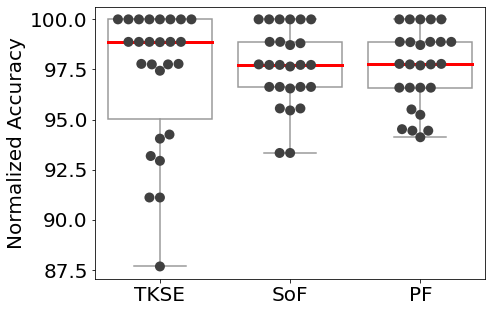

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize = (7,5))
plt.rcParams.update({'font.size': 20})

#colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.boxplot(data=[topk_percentage, sigma_percentage, qf_percentage], fliersize = 0, medianprops={'color':'red', 'linewidth': 3}, color='white')
sns.swarmplot(data=[topk_percentage, sigma_percentage, qf_percentage], color=".25", size = 10)

ax.set_xticklabels(['TKSE', 'SoF', 'PF'])
#major_ticks = np.arange(85, 101, 5)

#ax.set_yticks(major_ticks)
ax.set(ylabel = 'Normalized Accuracy')
plt.show()

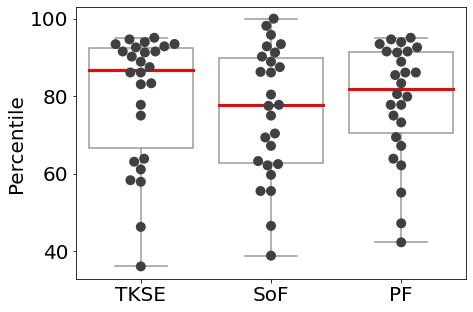

In [ ]:
f, ax = plt.subplots(figsize = (7,5))
plt.rcParams.update({'font.size': 20})

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.boxplot(data=[topk_percentile, sigma_percentile, qf_percentile], fliersize = 0, medianprops={'color':'red', 'linewidth': 3}, color='white')
sns.swarmplot(data=[topk_percentile, sigma_percentile, qf_percentile], color=".25", size = 10)

ax.set_xticklabels(['TKSE', 'SoF', 'PF'])
ax.set_ylim(top=103)
ax.set(ylabel = 'Percentile')
plt.show()

## Max accuracies (and f1-score) comparison

In [ ]:
from sklearn.metrics import f1_score

# diamo tutti i classificatori in input
combs = list(combinations(clfs, len(clfs)))
for comb in combs:
    classifier_names = str(comb)
        
    accuracy_distributions = []
    for input_clf in comb:
        if (input_clf['type'] == 'BOS'):
            clf = BOS_Classifier(eval(input_clf['name']))
        elif (input_clf['type'] == 'NLP'):
            clf = NLP_Classifier()
        elif (input_clf['type'] == 'TSC'):
            clf = eval(input_clf['name'])
        accuracy_distributions.append(k_accuracy_cv(clf, X_train, y_train))

    index_list, k = select_from_k_accuracy(accuracy_distributions, len(set(y_test)))
    selected_classifiers = select_from_index(index_list, comb)

    formatted_names = [re.sub(r'\([^()]*\)', '', x['name']) for x in comb]
    print("Combination: ", formatted_names)
    print("Selected classifiers: ", selected_classifiers)

    # massima accuracy ottenibile con sof e i classificatori scelti
    max_accuracy = max(results[classifier_names]['accuracies'])
    best_ordering = results[classifier_names]['best_ordering']
    best_sigma = results[classifier_names]['sigma']
    ensemble = EnsembleFramework(criterion = 'sof', layers = best_ordering, params = {'sigma': best_sigma})
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    max_f1 = f1_score(y_pred, y_test, average = 'macro')*100
    print("Max accuracy achievable {:.3f}".format(max_accuracy))
    print("f1 of the best combination {:.3f}".format(max_f1))

    # usiamo l'euristica sia per la selezione e l'ordinamento sia per ordinare il k
    ensemble = EnsembleFramework(criterion = 'topk', layers = selected_classifiers, params = {'k': k})
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    k_heuristic_accuracy = ensemble.accuracy(y_pred, y_test) 
    k_heuristic_f1 = f1_score(y_pred, y_test, average = 'macro')*100
    print("Accuracy with heuristic and topk {:.3f}".format(k_heuristic_accuracy))
    print("f1 with heuristic and topk {:.3f}".format(k_heuristic_f1))

    ensemble = EnsembleFramework(criterion = 'sof', layers = selected_classifiers)
    ensemble = sigma_grid_search_cv(ensemble, X_train, y_train, sigmas)
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    sigma_heuristic_accuracy = ensemble.accuracy(y_pred, y_test)
    sigma_heuristic_f1 = f1_score(y_pred, y_test, average = 'macro')*100
    print("Accuracy with heuristic and cross-validation with sof {:.3f}".format(sigma_heuristic_accuracy))
    print("f1 with heuristic and cross-validation with sof {:.3f}".format(sigma_heuristic_f1))

    ensemble = EnsembleFramework(criterion = 'qf', layers = selected_classifiers)
    ensemble = q_grid_search_cv(ensemble, X_train, y_train, qs)
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    qf_heuristic_accuracy = ensemble.accuracy(y_pred, y_test)
    qf_heuristic_f1 = f1_score(y_pred, y_test, average = 'macro')*100

    print("Accuracy with heuristic and cross-validation with qf {:.3f}".format(qf_heuristic_accuracy))
    print("f1 with heuristic and cross-validation with qf {:.3f}".format(qf_heuristic_f1))

In [ ]:
# diamo tutti i classificatori in input
combs = list(combinations(clfs, 2))
for comb in combs:
    classifier_names = str(comb)
        
    accuracy_distributions = []
    for input_clf in comb:
        if (input_clf['type'] == 'BOS'):
            clf = BOS_Classifier(eval(input_clf['name']))
        elif (input_clf['type'] == 'NLP'):
            clf = NLP_Classifier()
        elif (input_clf['type'] == 'TSC'):
            clf = eval(input_clf['name'])
        accuracy_distributions.append(k_accuracy_cv(clf, X_train, y_train))

    index_list, k = select_from_k_accuracy(accuracy_distributions, len(set(y_test)))
    selected_classifiers = select_from_index(index_list, comb)

    formatted_names = [re.sub(r'\([^()]*\)', '', x['name']) for x in comb]
    print("Combination: ", formatted_names)
    print("Selected classifiers: ", selected_classifiers)

In [ ]:
selected_classifiers

[{'name': 'TSC_1NN(metric = distance.euclidean)', 'type': 'TSC'},
 {'name': 'RandomForestClassifier(1000, random_state=100)', 'type': 'BOS'}]

# k-accuracy graph

In [ ]:
comb

({'name': 'TSC_1NN(metric = distance.euclidean)', 'type': 'TSC'},
 {'name': 'KNeighborsClassifier()', 'type': 'BOS'},
 {'name': 'GradientBoostingClassifier(random_state=100)', 'type': 'BOS'},
 {'name': 'RandomForestClassifier(1000, random_state=100)', 'type': 'BOS'},
 {'name': 'SVC(probability=True, random_state=100)', 'type': 'BOS'})

In [ ]:
len(accuracy_distributions)

5

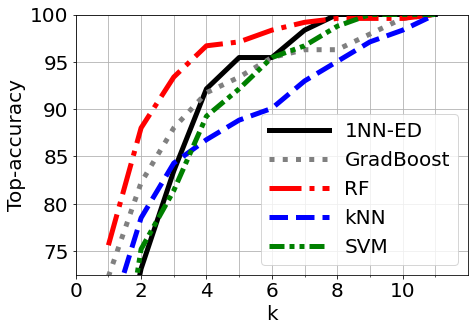

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'legend.handlelength': 3.0})

f, ax = plt.subplots(figsize=(7,5))
labels = np.arange(1, 12)
plt.plot(labels, accuracy_distributions[0], label='1NN-ED', linewidth = 5, color = 'black', linestyle = '-')
#plt.plot(labels, accuracy_distributions[2], label='NLP', linewidth = 5, color = 'orange', linestyle = (0, (3,1,1,1)))
plt.plot(labels, accuracy_distributions[2], label='GradBoost', linewidth = 5, color = 'grey', linestyle = ':')
plt.plot(labels, accuracy_distributions[3], label='RF', linewidth = 5, color = 'red', linestyle = '-.')

plt.plot(labels, accuracy_distributions[1], label='kNN', linewidth = 5, color = 'blue', linestyle = '--')
plt.plot(labels, accuracy_distributions[4], label='SVM', linewidth = 5, color = 'green', linestyle = (0, (3,1,1,1,1,1)))
#plt.grid()
#plt.plot(labels, accuracy_distributions[4], label='SVM')

plt.axis([0, 12, 72.5, 100])

major_ticks = np.arange(0, 12, 2)
minor_ticks = np.arange(0, 12, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='both')

#plt.title('Accuracy with varying sizes of k')
plt.xlabel('k', fontsize = 20)
plt.ylabel('Top-accuracy', fontsize = 20)
plt.legend()
plt.tight_layout()

plt.show()
#plt.savefig('thingspeak_kaccuracy.png')

# Comparison with Voting Classifier


Let's define a voting classifier (soft and hard voting), to see how it stacks up against our framework

In [ ]:
from sklearn.base import BaseEstimator

class Voting_Classifier(BaseEstimator):
    
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        
    def fit(self, X, y):
        for clf in self.estimators:
            clf.fit(X, y)
    
    def predict(self, X):
        if self.voting == 'soft':
            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)
            maj = np.apply_along_axis(
                lambda x: np.argmax(
                    np.bincount(x, weights=self._weights_not_none)),
                axis=1, arr=predictions)

        return maj
    
    def _collect_probas(self, X):
        """Collect results from clf.predict calls. """
        return np.asarray([clf.predict_proba(X) for clf in self.estimators])
    
    def _predict_proba(self, X):
        """Predict class probabilities for X in 'soft' voting """
        if self.voting == 'hard':
            raise AttributeError("predict_proba is not available when"
                                 " voting=%r" % self.voting)
        avg = np.average(self._collect_probas(X), axis=0)
        return avg
    
    def predict_proba(self, X):
        """Compute probabilities of possible outcomes for samples in X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        avg : array-like, shape (n_samples, n_classes)
            Weighted average probability for each class per sample.
        """
        return self._predict_proba(X)

In [ ]:
clfs = []
clfs.append(BOS_Classifier(eval('KNeighborsClassifier()')))
clfs.append(BOS_Classifier(eval('GradientBoostingClassifier(random_state=100)')))
clfs.append(BOS_Classifier(eval('RandomForestClassifier(1000, random_state=100)')))
#clfs.append(BOS_Classifier(eval('SVC(probability=True, random_state=100)')))
clfs.append(NLP_Classifier())
clfs.append(TSC_1NN(metric = distance.euclidean))

In [ ]:
voting = Voting_Classifier(clfs, voting = 'soft')
voting.fit(X_train, y_train)

In [ ]:
y_pred = voting.predict(X_test)

In [ ]:
#thingspeak
print(accuracy_score(y_pred, y_test))
print(f1_score(y_pred, y_test, average = 'macro'))

0.7959183673469388
0.5778161776004728


In [ ]:
#swissex
print(accuracy_score(y_pred, y_test))
print(f1_score(y_pred, y_test, average = 'macro'))

0.8365384615384616
0.8160812859793514


In [ ]:
#urbanobs
print(accuracy_score(y_pred, y_test))
print(f1_score(y_pred, y_test, average = 'macro'))

0.890625
0.8642973156257161
